# Clustring other than hSBM
Run LDA, wgcna, topic mapping and hierarchical

In [1]:
%load_ext watermark
%watermark -v -m  -u -n -p pandas,numpy,seaborn,tensorflow,sklearn,scipy,topicpy -a Filippo_Valle -g -r -b -w

2023-02-28 12:02:10.960576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 12:02:11.050577: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-28 12:02:11.050594: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-28 12:02:11.658807: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Author: Filippo_Valle

Last updated: Tue Feb 28 2023

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.9.0

pandas    : 1.5.3
numpy     : 1.23.5
seaborn   : 0.12.2
tensorflow: 2.11.0
sklearn   : 0.0
scipy     : 1.10.0
topicpy   : 0.2.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.19.0-31-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

Git hash: 693a7742fc39df010099b6115ab8da1628053ad0

Git repo: git@github.com:fvalle1/topics.git

Git branch: HEAD

Watermark: 2.3.1



In [2]:
import matplotlib.pyplot as plt  
import pandas as pd  
import numpy as np 
import seaborn as sns
import os, sys
from topicpy.hsbmpy import get_file, define_labels, get_cluster_given_l, get_max_available_L
from topicpy.geneontology import topic_analysis
import tensorflow as tf
from sklearn.metrics import homogeneity_completeness_v_measure
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr
from sklearn.decomposition import LatentDirichletAllocation
from topicpy.lda import lda

In [3]:
os.chdir('/home/jovyan/work/phd/topics/')

In [4]:
level = 2
directory=f"{os.getcwd()}/unified"
#L=get_max_available_L(directory)
os.chdir(directory)
os.getcwd()

'/home/jovyan/work/phd/topics/unified'

In [5]:
df = pd.read_csv("mainTable.csv", index_col=[0], header=[0]).dropna()
totalobjcets = len(df.columns)
print(df.info())
print("Maximum expression value: %.1e"%df.max().max())
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 18154 entries, A1BG to hsa-mir-1199
Columns: 9147 entries, TCGA-KM-8639-01A-11R-2403-07 to TCGA-64-1680-01A-02R-0946-07
dtypes: float64(9147)
memory usage: 1.2+ GB
None
Maximum expression value: 4.8e+11


,TCGA-KM-8639-01A-11R-2403-07,TCGA-KL-8339-01A-11R-2315-07,TCGA-KN-8419-01A-11R-2315-07,TCGA-KM-8438-01A-11R-2315-07,TCGA-KL-8337-01A-11R-2315-07,TCGA-KL-8324-01A-11R-2315-07,TCGA-KL-8325-01A-11R-2315-07,TCGA-KM-8442-01A-11R-2315-07,TCGA-KO-8411-01A-11R-2315-07,TCGA-KN-8418-01A-11R-2315-07,...,TCGA-78-7163-01A-12R-2066-07,TCGA-44-5645-01A-01R-A278-07,TCGA-86-7713-01A-11R-2066-07,TCGA-69-7764-01A-11R-2170-07,TCGA-86-7954-01A-11R-2187-07,TCGA-86-8056-01A-11R-2241-07,TCGA-64-5815-01A-01R-1628-07,TCGA-44-3398-01A-01R-1107-07,TCGA-55-6970-01A-11R-1949-07,TCGA-64-1680-01A-02R-0946-07
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
A1BG,49.21,16.88,56.68,85.22,46.18,37.59,32.36,191.67,36.79,48.87,...,19.53,215.77,420.68,114.36,299.25,122.64,447.82,764.36,397.93,1477.58
A2M,2335.28,1857.60,3467.27,6516.03,2271.40,2209.26,1674.06,2119.22,2537.92,2047.00,...,1277.29,17437.64,10154.69,9409.14,7911.95,13215.02,11112.30,13776.25,11992.79,4769.75


In [6]:
df_files = pd.read_csv("files.dat", index_col=[0])
df_files.head(3)

,primary_site,status,dataset,dataset_status,tissue_hd
TCGA-KM-8639-01A-11R-2403-07,Kidney,tumor,tcga,tcga_tumor,Kidney_tcga
TCGA-KL-8339-01A-11R-2315-07,Kidney,tumor,tcga,tcga_tumor,Kidney_tcga
TCGA-KN-8419-01A-11R-2315-07,Kidney,tumor,tcga,tcga_tumor,Kidney_tcga


In [7]:
true_out = []
label = "primary_site"
if label not in df_files.columns:
    raise AttributeError(f"{label} not Avaliable")
for sample in df.columns.values:
    try:
        true_out.append(get_file(sample, df_files)[label])
    except:
        print(*sys.exc_info())
        true_out.append('unknown')

In [8]:
scores = {}

In [9]:
try:
    with open("clustersizes.txt",'r') as f:
        xl = np.sort(np.array(f.read().split(sep='\n'))[:-1].astype(int))
except:
        xl=np.linspace(2,50,3, dtype=int)
xl

array([  1,   6,  20, 128, 800])

In [10]:
xl=xl[:-1]
xl

array([  1,   6,  20, 128])

# hierarchical

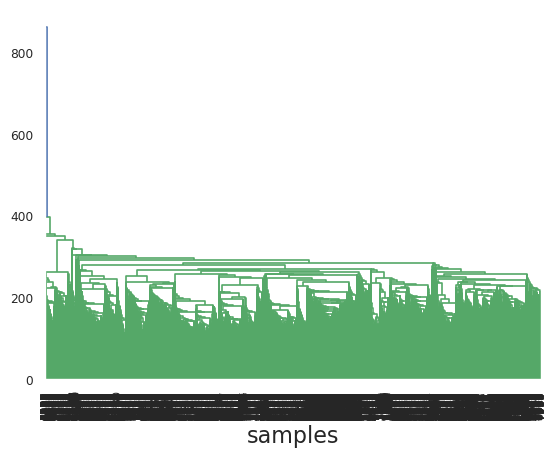

In [12]:
fig=plt.figure()
dend = shc.dendrogram(shc.linkage(np.log2(df.T.values+1), method='average'), leaf_rotation=90., leaf_font_size=8.,)
plt.xlabel("samples", fontsize=16)
plt.show()
fig.savefig("hierarchical_dendogram.pdf")

In [13]:
#hierarchical
scores['hierarchical']={
    'h':[],
    'c':[],
    'V':[]
}
def pearson_affinity(M, parallel=True):
    return 1. - np.array([[pearsonr(a,b)[0] for a in M] for b in M])

print("hierarchical-log")
os.system('mkdir -p hierarchical-log')
hierarchical_model = AgglomerativeClustering(n_clusters=1, affinity='euclidean', linkage='complete')  
for l,x in enumerate(xl):
    print("testing with %d clusters"%x)
    hierarchical_model.n_clusters=x
    data = np.log2(1.+df.T.values)
    #data = df.T.values
    out = hierarchical_model.fit_predict(data)
        
    #save clusters
    print("saving clusters")
    df_clusters = pd.DataFrame(index=np.arange(len(df.columns)))
    for c in np.arange(out.max()+1)[::-1]:
        c_objects = df.columns[np.argwhere(out==c)].T[0]
        df_clusters.insert(0,"Cluster %d"%(c+1),np.concatenate((c_objects,[np.nan for _ in np.arange(len(df.columns)-len(c_objects))])))
    df_clusters.dropna(axis=0,how='all', inplace=True)
    df_clusters.to_csv("hierarchical-log/hierarchical-log_level_%d_clusters.csv"%(l), index=False, header=True)

hierarchical-log
testing with 1 clusters


/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


saving clusters
testing with 6 clusters


/tmp/ipykernel_23451/2872728871.py:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out==c)].T[0]
/opt/conda/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


saving clusters
testing with 20 clusters


/tmp/ipykernel_23451/2872728871.py:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out==c)].T[0]
/tmp/ipykernel_23451/2872728871.py:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out==c)].T[0]
/tmp/ipykernel_23451/2872728871.py:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out==c)].T[0]
/tmp/ipykernel_23451/2872728871.py:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a 

saving clusters
testing with 128 clusters


/tmp/ipykernel_23451/2872728871.py:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out==c)].T[0]
/tmp/ipykernel_23451/2872728871.py:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out==c)].T[0]
/tmp/ipykernel_23451/2872728871.py:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out==c)].T[0]
/tmp/ipykernel_23451/2872728871.py:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a 

saving clusters


/tmp/ipykernel_23451/2872728871.py:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out==c)].T[0]
/tmp/ipykernel_23451/2872728871.py:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out==c)].T[0]
/tmp/ipykernel_23451/2872728871.py:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out==c)].T[0]
/tmp/ipykernel_23451/2872728871.py:24: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a 

# LDA

In [11]:
with open("topicsizes.txt",'r') as f:
    tl = np.array(f.read().split(sep='\n'))[:-1].astype(int)

In [12]:
xl = xl[:5]
print(xl)

[  1   6  20 128]


In [13]:
model=lda(n_jobs=4, verbose=2,  max_iter=5)
model.full_analysis(directory, xl, tl=None, logarithmise=False, label="tissue_hd")

model created
<class 'pandas.core.frame.DataFrame'>
Index: 18154 entries, A1BG to hsa-mir-1199
Columns: 9147 entries, TCGA-KM-8639-01A-11R-2403-07 to TCGA-64-1680-01A-02R-0946-07
dtypes: float64(9147)
memory usage: 1.2+ GB
None
<class 'pandas.core.frame.DataFrame'>
Index: 9147 entries, TCGA-KM-8639-01A-11R-2403-07 to TCGA-64-1680-01A-02R-0946-07
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   primary_site    9147 non-null   object
 1   status          9147 non-null   object
 2   dataset         9147 non-null   object
 3   dataset_status  9147 non-null   object
 4   tissue_hd       9147 non-null   object
dtypes: object(5)
memory usage: 428.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 9147 entries, TCGA-KM-8639-01A-11R-2403-07 to TCGA-64-1680-01A-02R-0946-07
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   primary_site    9147

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 1 of max_iter: 5


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]

iteration: 2 of max_iter: 5


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]

iteration: 3 of max_iter: 5


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]

iteration: 4 of max_iter: 5


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using ba

iteration: 5 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.7s remaining:    1.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.5s remaining:    1.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.8s finished


saving word-distr
saving topic-distr
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-02-28 12:04:47.086083: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-28 12:04:47.086367: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-28 12:04:47.086387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (8d3dbf46661d): /proc/driver/nvidia/version does not exist
2023-02-28 12:04:47.095567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


saving clusters
saving metrics


/opt/conda/lib/python3.9/site-packages/topicpy/lda/lda.py:156: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out == c)].T[0]
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.7s finished


testing with 6 clusters and 6 topics
lda()


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 1 of max_iter: 5


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]

iteration: 2 of max_iter: 5


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]

iteration: 3 of max_iter: 5


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]

iteration: 4 of max_iter: 5


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using ba

iteration: 5 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    4.2s remaining:    4.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    3.7s remaining:    3.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    4.5s finished


saving word-distr
saving topic-distr
saving clusters
saving metrics


/opt/conda/lib/python3.9/site-packages/topicpy/lda/lda.py:156: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out == c)].T[0]
/opt/conda/lib/python3.9/site-packages/topicpy/lda/lda.py:156: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out == c)].T[0]
/opt/conda/lib/python3.9/site-packages/topicpy/lda/lda.py:156: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out == c)].T[0]
/opt/conda/lib/python3.9/site-packages/topicpy/lda/lda.py:156: FutureWarning: Support for multi-dimensiona

testing with 20 clusters and 20 topics
lda()


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 1 of max_iter: 5


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]

iteration: 2 of max_iter: 5


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]

iteration: 3 of max_iter: 5


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]

iteration: 4 of max_iter: 5


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]

iteration: 5 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   10.7s remaining:   10.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   11.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   11.2s remaining:   11.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   11.4s finished


saving word-distr
saving topic-distr
saving clusters
saving metrics


/opt/conda/lib/python3.9/site-packages/topicpy/lda/lda.py:156: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out == c)].T[0]
/opt/conda/lib/python3.9/site-packages/topicpy/lda/lda.py:156: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out == c)].T[0]
/opt/conda/lib/python3.9/site-packages/topicpy/lda/lda.py:156: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out == c)].T[0]
/opt/conda/lib/python3.9/site-packages/topicpy/lda/lda.py:156: FutureWarning: Support for multi-dimensiona

testing with 128 clusters and 128 topics
lda()


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.4s remaining:    5.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.3s remaining:    5.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.4s remaining:    5.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.5s remaining:    5.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Don

iteration: 1 of max_iter: 5


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.4s remaining:    5.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.0s remaining:    5.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.5s remaining:    5.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.4s remaining:    5.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.3s remaining:    5.3s
[Parallel(n_jobs=4)]

iteration: 2 of max_iter: 5


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.4s remaining:    5.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.5s remaining:    5.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.4s remaining:    5.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.5s remaining:    5.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.4s remaining:    5.4s
[Parallel(n_jobs=4)]

iteration: 3 of max_iter: 5


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.4s remaining:    5.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.5s remaining:    5.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.5s remaining:    5.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.6s remaining:    5.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.3s remaining:    5.3s
[Parallel(n_jobs=4)]

iteration: 4 of max_iter: 5


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.4s remaining:    5.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.6s remaining:    5.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.4s remaining:    5.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.6s remaining:    5.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.5s remaining:    5.5s
[Parallel(n_jobs=4)]

iteration: 5 of max_iter: 5


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.1min remaining:  2.1min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.1min remaining:  2.1min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.1min finished


saving word-distr
saving topic-distr


2023-02-28 13:02:12.285871: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2379481088 exceeds 10% of free system memory.
2023-02-28 13:02:12.697935: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2379481088 exceeds 10% of free system memory.


saving clusters


/opt/conda/lib/python3.9/site-packages/topicpy/lda/lda.py:156: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out == c)].T[0]
/opt/conda/lib/python3.9/site-packages/topicpy/lda/lda.py:156: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out == c)].T[0]
/opt/conda/lib/python3.9/site-packages/topicpy/lda/lda.py:156: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_objects = df.columns[np.argwhere(out == c)].T[0]
/opt/conda/lib/python3.9/site-packages/topicpy/lda/lda.py:156: FutureWarning: Support for multi-dimensiona

saving metrics


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  2.1min remaining:  2.1min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  2.1min finished


# Topic mapping

In [ ]:
df=pd.read_csv("mainTable.csv", index_col=0)
df.info()
df.head(2)

In [ ]:
with open("corpus.txt",'w') as file:
    for sample in df.columns:
        for g in np.array(df[sample].sort_values(ascending=False).index[:1000],dtype=str):
            file.write(g[:15])
            file.write(" ")
        file.write("\n")
import gc
gc.collect()

Instructions on how to install it are available from its authors
[https://amaral.northwestern.edu/resources/software/topic-mapping](https://amaral.northwestern.edu/resources/software/topic-mapping)

run this in the shell
```bash
export PATH=$PATH:/home/jovyan/work/topicmapping/bin
topicmap -f corpus.txt -r 10 -t 10 -seed 42 -o tm
```

In [ ]:
os.system("export PATH=$PATH:/home/jovyan/work/topicmapping/bin")
os.system("topicmap -f corpus.txt -r 10 -t 10 -seed 42 -o tm")

In [ ]:
df_words = pd.read_csv("tm/word_wn_count.txt", sep=' ', header=None)
df_words.columns=['word', 'word-id', 'occurrence']
df_words.sort_values('word-id')

In [ ]:
df_topic_distr = pd.read_csv("tm/lda_gammas_final.txt", sep=' ', header=None)
df_topic_distr.columns=['Topic %d'%(t+1) for t in df_topic_distr.columns]
df_topic_distr.index.name='i_doc'
df_topic_distr.insert(0,'doc',df.columns)
df_topic_distr=df_topic_distr.dropna(how='all',axis=1)

In [ ]:
clusters = df_topic_distr.drop('doc',1).values.argmax(1)
df_clusters=pd.DataFrame()
for cluster in range(np.max(clusters)+1):
    elems=df.columns[clusters==cluster].values
    df_clusters.insert(0,'Cluster %d'%(cluster+1),np.concatenate([elems, ['' for _ in range(len(df.columns)- len(elems))]]))

In [ ]:
df_clusters.sort_index(axis=1).to_csv("tm/tm_level_0_clusters.csv", index=False, header=True)
df_topic_distr.to_csv("tm/tm_level_0_topic-dist.csv", index=True, header=True)

In [ ]:
df_word_distr = pd.DataFrame().fillna(0)
with open("tm/lda_betas_sparse_final.txt","r") as f:
    for line in f.read().split("\n"):
        row = line.split(" ")
        if len(row) < 2:
            continue
        topic = int(row[0])+1
        line=np.array(row[1:-1], dtype=float).reshape(int((len(row)-1)/2),2)
        for el in line:
            df_word_distr.at[df_words[df_words['word-id']==int(el[0])].word.values[0], f"Topic {topic}"] = el[1]
#df_word_distr.index=df_words['word']
df_word_distr.fillna(0)
df_word_distr.to_csv("tm/tm_level_0_word-dist.csv", index=True, header=True)

In [ ]:
df_topics = pd.DataFrame()
max_L = df_word_distr.shape[0]
for topic in df_word_distr.columns[::-1]:
    t_series = df_word_distr[topic]
    t_series = t_series[t_series>t_series.quantile(0.99)]
    df_topics.insert(0,topic,np.concatenate((t_series.index.values,np.repeat(np.nan, df_word_distr.shape[0]-len(t_series)))))
df_topics.dropna(how="all", axis=0).to_csv("tm/tm_level_0_topics.csv", index=False, header=True)

# WGCNA

Use [WGCNA.ipynb](WGCNA.ipynb) to run analyses before continuing and store data in the next step

In [ ]:
from hsbmpy import get_max_available_L
for l in range(get_max_available_L(directory, "wgcna")+1):
    df_wgcna = pd.read_csv("wgcna/wgcna_level_%d_labels.csv"%l, index_col=0)
    totalobjcets = len(df_wgcna.index)
    out = df_wgcna['x'].values
    print("saving clusters")
    df_clusters = pd.DataFrame(index=np.arange(totalobjcets))
    for c in np.arange(out.max()+1)[::-1]:
        c_objects = df_wgcna.index[np.argwhere(out==(c+1))].T[0]
        df_clusters.insert(0,"Cluster %d"%(c+1),np.concatenate((c_objects,[np.nan for _ in np.arange(totalobjcets-len(c_objects))])))
    df_clusters.dropna(axis=0,how='all', inplace=True)
    df_clusters.to_csv("wgcna/wgcna_level_%d_clusters.csv"%l, index=False, header=True)
df_wgcna_td = pd.read_csv("wgcna/wgcna_level_0_topic-dist.csv")
df_wgcna_td.columns.values[0]='doc'
df_wgcna_td.index.name='i_doc'
df_wgcna_td.to_csv("wgcna/wgcna_level_0_topic-dist.csv", index=True)

In [ ]:
df_word_distr = pd.read_csv("wgcna/wgcna_level_0_word-dist.csv", index_col=0)
df_topics = pd.DataFrame()
max_L = df_word_distr.shape[0]
for topic in df_word_distr.columns[::-1]:
    t_series = df_word_distr[topic]
    t_series = t_series[t_series>0.5]
    df_topics.insert(0,topic.replace("MM","ME"),np.concatenate((t_series.index.values,np.repeat(np.nan, df_word_distr.shape[0]-len(t_series)))))
df_topics.dropna(how="all", axis=0).to_csv("wgcna/wgcna_level_0_topics.csv", index=False, header=True)